# Time Series Coursework 1

My coursework analysing SP500 time series data.

## Question 1

### (a)

In [ ]:
#all liberies
library(quantmod)
library(tseries)
library(lmtest)
library(forecast)
library(rugarch)
library(xts)
library(FinTS)
library(fGarch)
library(PerformanceAnalytics)

[1] "^GSPC"

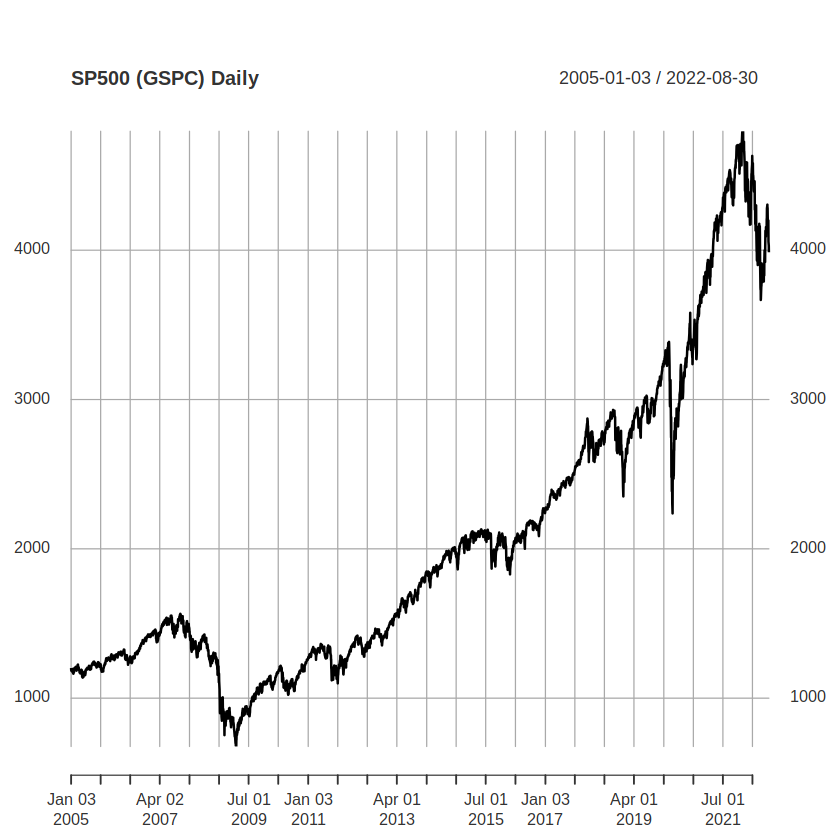

In [2]:
#Downloading SP500 data
getSymbols("^GSPC", from = "2005-01-01", to = "2022-08-31")
#chartSeries(GSPC, theme = "white")
#head(GSPC)

y <- GSPC$GSPC.Close
plot(y,main = "SP500 (GSPC) Daily")

We see that there is an increasing trend over time. Closing price has gone up. There are some downtrends in 2008, 2015, 2016,2018 and 2020, and the most recent downtrend is in 2021. It is clear, this is not a stationary series in mean and variance.

Possible causes could be, the 2008 market crash, 2020 covid 19, and maybe the war in Ukraine for 2021/2022

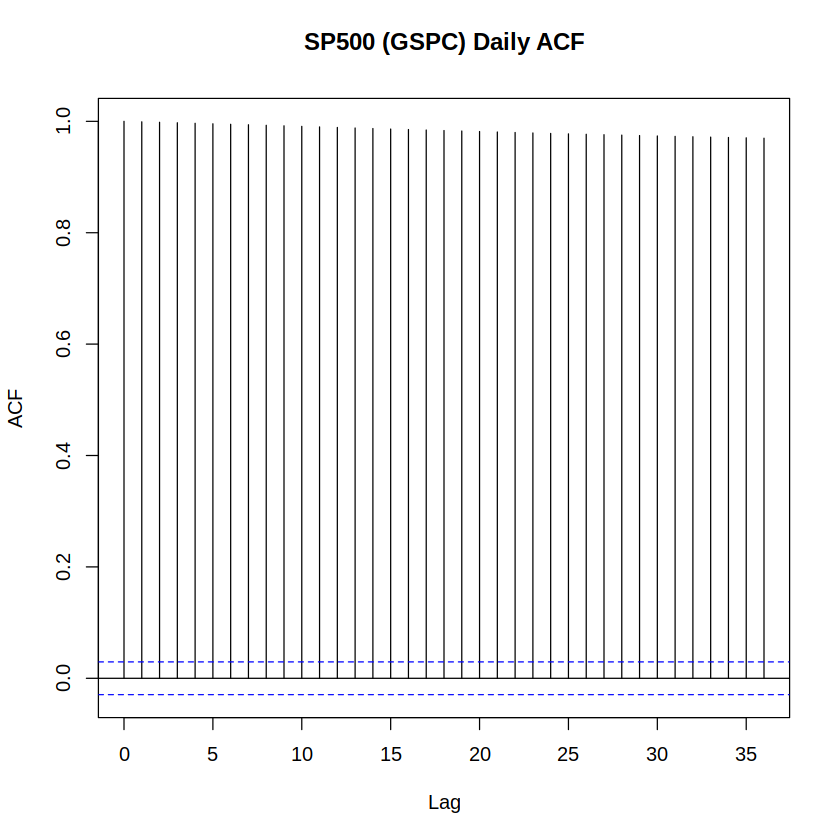

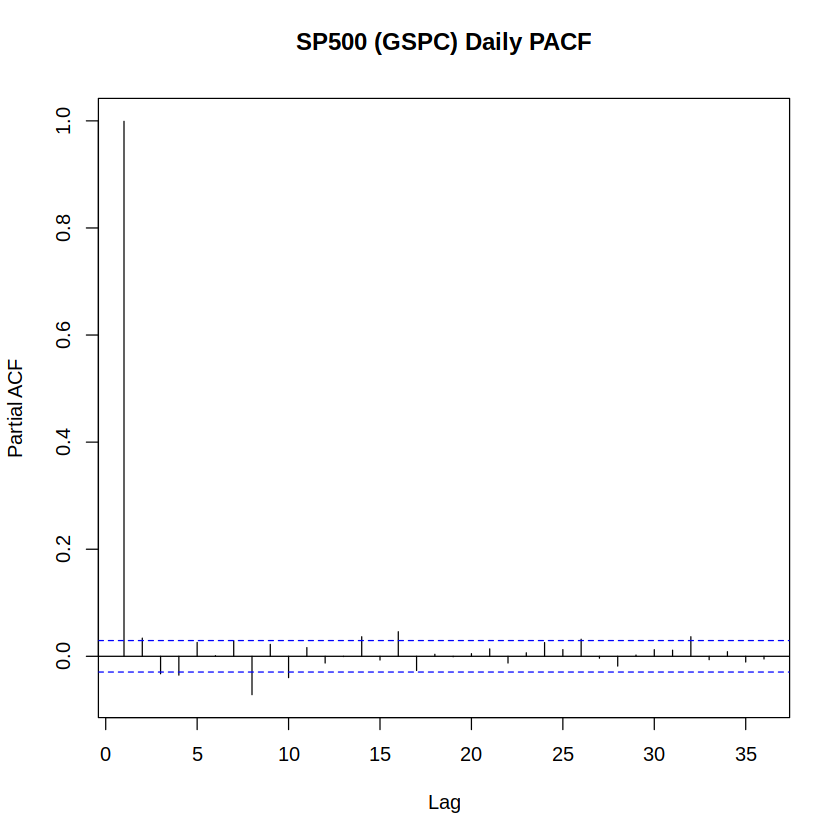

In [3]:
acf(y, main = "SP500 (GSPC) Daily ACF")
pacf(y, main = "SP500 (GSPC) Daily PACF")

Looking at the ACF of closing price, we see very high correlation, and it confirms that the series is non stationariy in the mean and variance. 

### (b)

Log returns

$R_t = \frac{P_t-P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$

Where $P_t$ is the series we want to find the returns for. In this case the logged closing price of SP500

             GSPC.Close
2005-01-04 -0.011740004
2005-01-05 -0.003634440
2005-01-06  0.003499727
2005-01-07 -0.001432196
2005-01-10  0.003416929
2005-01-11 -0.006118246

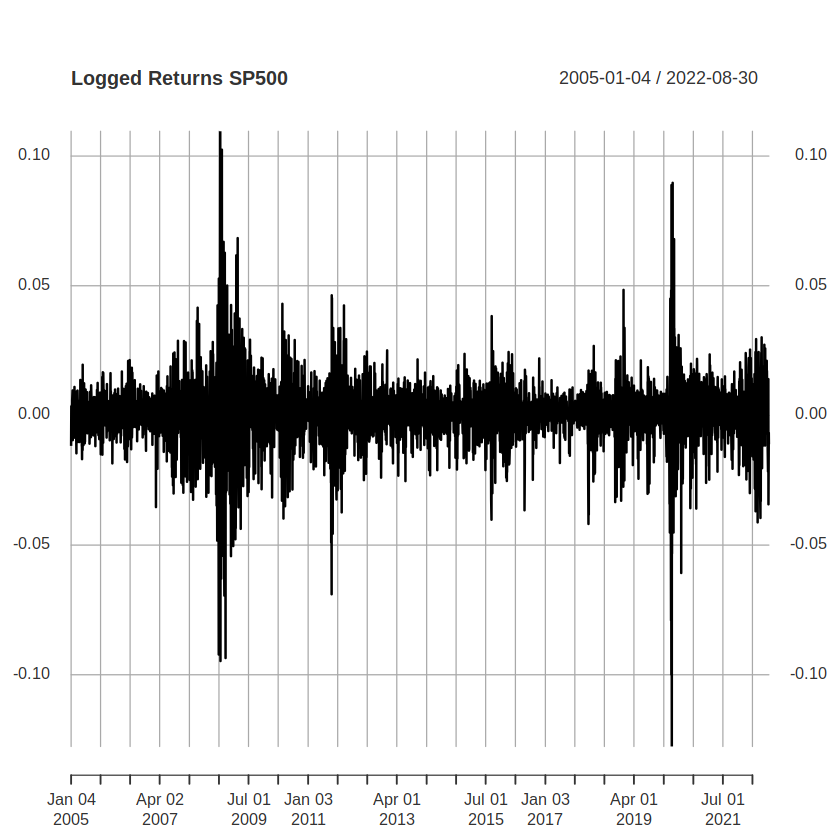

In [4]:
y_log <- log(y)
rt <- diff(y_log)

rt = rt[-c(1),]
head(rt)
plot(rt, main = "Logged Returns SP500")

We can see that the mean log return is almost zero. Volitily seems largest during 2008, and around 2020. Which is consistant with the fluctuations we saw in the daily close price time series. It seems to have stationary mean, and variance.

### (c)

Expressed log returns as precentages

I left the precentage as is. I didnt do *100, for example. 0.5 we know is 50%, i didnt make it 0.5*100 = 50%

In [5]:
rt_percent <- diff(y_log)/y_log[-nrow(y_log),]
rt_percent = rt_percent[-c(1),]
head(rt_percent)

              GSPC.Close
2005-01-04 -0.0016581766
2005-01-05 -0.0005135976
2005-01-06  0.0004943164
2005-01-07 -0.0002023304
2005-01-10  0.0004824863
2005-01-11 -0.0008646719

In [6]:
comp <- data.frame(mean = mean(rt_percent),
           std= sd(rt_percent),
           kurtosis = kurtosis(rt_percent),
           skewness = skewness(rt_percent),
           min = min(rt_percent),
           max = max(rt_percent))

comp

mean,std,kurtosis,skewness,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.40067e-05,0.001696224,14.2033,-0.5403758,-0.01641316,0.01585449


We see that the mean is almost 0, however the std is around 0.169%. Which is above 0, but is close to it. Looking at the minimum and maximum, they, around -1.64% and 1.58%. So there are high and low fluctuations in the series.

Kurtosis is around 14.2033, which is much larger than the normal distribution, which has about 3. This suggests that the SP500 returns percentages have heavier tails than the normal. 

Skewness is -0.5404 which is between -1 and -0.5. So it suggests that the data is moderately skewed. The negative value might suggests the distribution has a long left tail.


### (d)

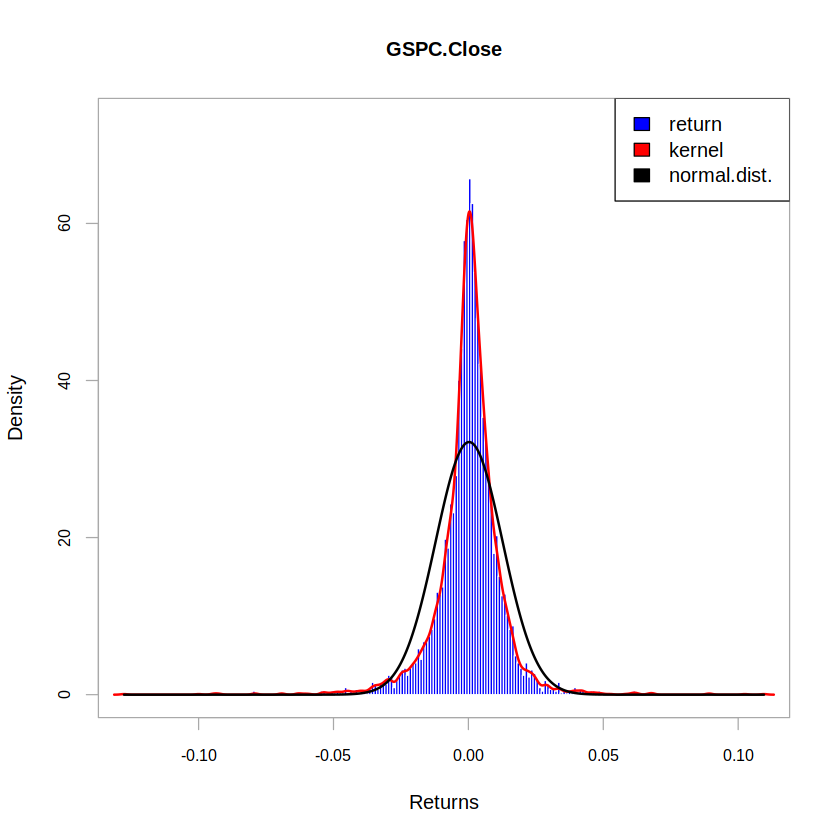

In [7]:
chart.Histogram(rt, methods = c("add.density", "add.normal"), colorset = c("blue", "red", "black"))

legend("topright", legend = c("return", "kernel", "normal.dist."), fill = c("blue","red", "black"))

Distribution of rt is more skewed than the normal distribution. Suggesting that considering the normal distribution is not a good choice for the returns.

The student t distribution might be. Which is more adaptable. We can be confirm this later by comparing models.

### (e)

Jarque and Bera Test for normality of the log returns:

$H_0:$ *Log returns come from a normal distribution*

$H_1:$ *Log returns do not come from a normal distribution*

$\alpha = 0.05$

In [8]:
jarque.bera.test(rt)


	Jarque Bera Test

data:  rt
X-squared = 32464, df = 2, p-value < 2.2e-16


Since the *p-value* $< 0.05 \Rightarrow$ Reject $H_0$ 

Conclude, the data suggests that the log returns do not come from a normal distribution

## Question 2

### (a)

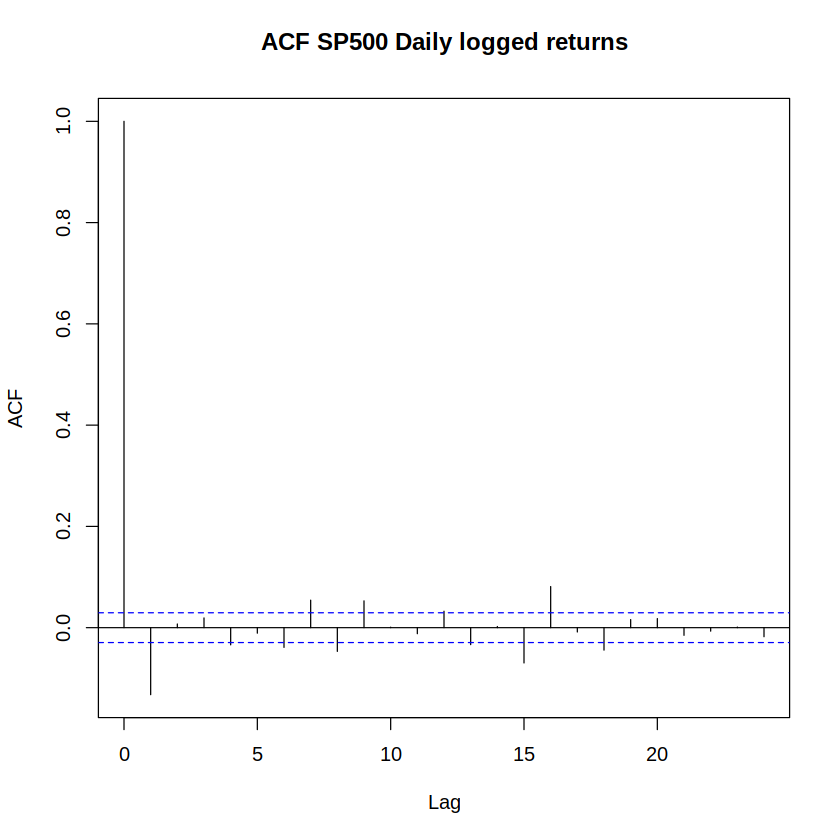

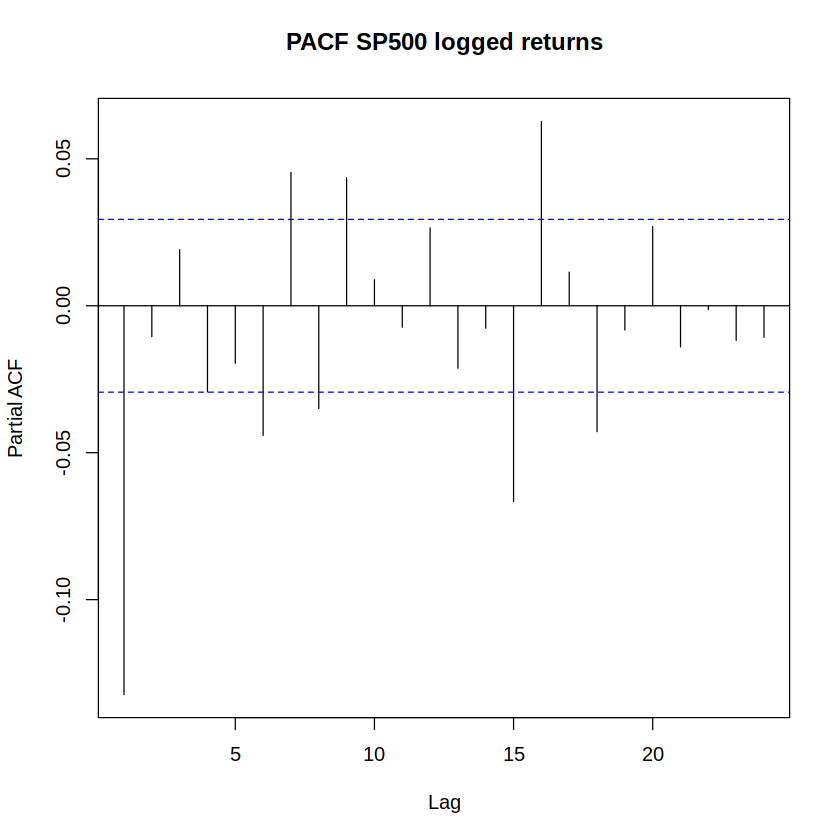

In [9]:
acf(rt, main = "ACF SP500 Daily logged returns", lag = 24 )
pacf(rt, main = "PACF SP500 logged returns", lag = 24)

Looking at the ACF and PACF plots, it is not clear whether they are tailing off or cutting off. There are several autocorelations that are significantly non zero. For example at lag 1, 4,6,7,15,16.

We can try to use $ARMA(p,q)$ model. We can test different p and q combinations, and decide on which model is better by picking the lowest AIC score.

### (b)

Testing for ARCH effect on the log returns. Using Lagrange Multiplier for the residuals with 1,12,24 lags of autocorrelation and 5% significance.

$e_t^2 = \alpha_0 + \alpha_1 e_{t-1}^2+...+e_{t-p}^2$ 

$H_0$: *There is no ARCH effect* or $\alpha_1=0=\alpha_{p}$

$H_1$: *There is ARCH effect*




In [10]:
arch.max <- matrix(0,20)

for (p in 1:20){
  arch.max[p]<- ArchTest(rt, lags = p, demean = TRUE)$p.value
} 

#display results
round(t(arch.max),6)

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


$p-values < 0.05 \Rightarrow$ Reject $H_0$ for lags from 1-20


Lagrange Multiplier test shows strong ARCH effects from 1-20 lags. So we need to use the model

$e_t^2 = \alpha_0 + \alpha_1 e_{t-1}^2+...+e_{t-20}^2$ 


### (c)

Fitting the log returns with ARCH(1), and GARCH(1,1) models.

In [11]:
#GARCH(1,1)
garchSpec <- ugarchspec(variance.model=list(model="sGARCH",
garchOrder=c(1,1)),
mean.model=list(include.mean=TRUE,armaOrder=c(0,0)),
distribution.model="norm")
garchFit1 <- ugarchfit(spec=garchSpec, data=rt)
coef(garchFit1)
show(garchFit1)

mu        omega       alpha1        beta1 
6.726884e-04 2.801526e-06 1.414351e-01 8.374434e-01


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000673    0.000113   5.9448  0.00000
omega   0.000003    0.000001   3.3458  0.00082
alpha1  0.141435    0.010860  13.0235  0.00000
beta1   0.837443    0.011506  72.7841  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000673    0.000103  6.52733  0.00000
omega   0.000003    0.000005  0.60281  0.54664
alpha1  0.141435    0.019338  7.31389  0.00000
beta1   0.837443    0.040314 20.77319  0.00000

LogLikelihood : 14543.2 

Information Criteria
------------------------------------
                    
Akaike       -6.5418
Bayes        -6.5361
Shibata      -6.5418
Hannan-Quinn -6.5398

Weigh

In [12]:
#ARCH(1)
garchSpec <- ugarchspec(variance.model=list(model="sGARCH",
garchOrder=c(1,0)),
mean.model=list(include.mean=FALSE,armaOrder=c(0,0)),
distribution.model="norm")
garchFit2 <- ugarchfit(spec=garchSpec, data=rt)
coef(garchFit2)
show(garchFit2)

omega       alpha1 
8.925621e-05 4.789620e-01


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000089    0.000003   32.801        0
alpha1  0.478962    0.038229   12.529        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000089     0.00001   8.9995  0.0e+00
alpha1  0.478962     0.11376   4.2102  2.6e-05

LogLikelihood : 13649.99 

Information Criteria
------------------------------------
                    
Akaike       -6.1408
Bayes        -6.1379
Shibata      -6.1408
Hannan-Quinn -6.1398

Weighted Ljung-Box Test on Standardized Residuals
------------------------------------
                        statistic  p-value
Lag[1]                      8.323 0.003914
Lag[2*(p+q)+(p+q)-1

<font size = 4> **Optimal Parameters**: </font>

We see that all parameters are statistically significant to a 5% significance level. So they should be there. Our equations are:

**ARCH(1):**

- $\sigma_t^2 = \omega + \alpha e_{t-1}^2= 0.000001 + 0.478962e_{t-1}^2$ 

**GARCH (1,1):**

- $\sigma_t^2 = \omega + \alpha e_{t-1}^2+\beta\sigma_{t-1}^2 = 0.000003 + 0.141435e_{t-1}^2 +0.837443\sigma_{t-1}^2$ 

- $r_t = \mu_0 + e_t = 0.000673 + e_t $ 

---

<font size = 4>**Information Criteria**</font>

Information Criteria helps us avoid choosing over complicated models. Simpler models have lower information criteria. 

AIC (Akaike Information Criteria). Compare with other models.

- AIC for ARCH(1) Model: -6.1408

- AIC for GARCH(1,1) Model: -6.541825

---

<font size = 4>**Weighted Ljung-Box Test on Standardized Residuals**</font>

Testing for serial correlation of the error terms

Ljung-Box Test:

$H_0:$ *No Serial Correlation*

$H_1:$ *Serial Correlation exists*

All $pvalues<0.05$ in the GARCH(1,1) and the ARCH(1) $\Rightarrow$ Reject $H_0$

Conclude that, data suggests that seroial correlation exists

---

<font size = 4>**Weighted Ljung-Box Test on Standardized Squared Residuals:**</font>

Simular analysis on the Weighted Ljung-Box Test except on Standardized squared Residuals. 

For the ARCH(1): 

- Model, All $pvalues<0.05 \Rightarrow$ Reject $H_0$

- so conclude that there is evidence of serial correlation, and hence they do not behave like white noise process.

For the GARCH(1,1):
- Model, All $pvalues>0.05 \Rightarrow$ Do not Reject $H_0$

- so conclude that there is no evidence of serial correlation, and hence they behave like white noise process?

---

<font size = 4>**Adjusted Pearson Goodness-of-Fit Test:**</font>

Check if the error term follows the normal distribution.

$H_0:$ *The conditional error term follows a normal distribution*

$H_1:$ *The conditional error term does not follows a normal distribution*

For the ARCH(1): 

- Model, All $pvalues<0.05 \Rightarrow$ Reject $H_0$

- So conclude that there is no evidence to suggest that the conditional error term follows a normal distribution.

For the GARCH(1,1):
- Model, All $pvalues<0.05 \Rightarrow$ Reject $H_0$

- So conclude that there is no evidence to suggest that the conditional error term follows a normal distribution.
---

Looking at the results, we see that our assumption of normality is not satisfied. When comparing the histogram of the return data and normal distribution, and looking at the kurtosis, and skewness from **question 1** we saw that the $r_t$ did not follow a normal distribution, thus it is not that suprising to see our normality assumption not met. Maybe a student t or a skwed student t distribution, or a different type of distribution would be better. If that still does not work, maybe fitting a simpler model would help.



Looking at the AIC, the GARCH(1,1) model has a lower AIC score than ARCH(1). So the GARCH(1,1) model is the better model judging fron this criteria.





please wait...calculating quantiles...


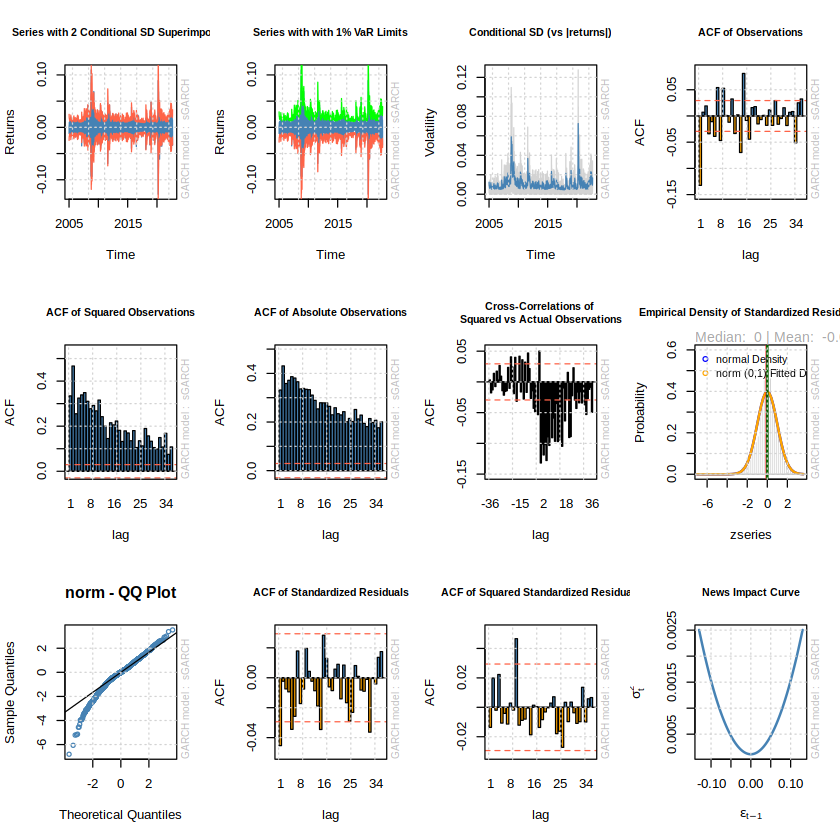

In [13]:
plot(garchFit1, which="all")

Looking at the graph, we can see that the peroid with high volatility has been captured by the model. We can see spikes in 2008, 2012, and 2020.